In [1]:
mkdir ~/.kaggle

In [2]:
!pip install kaggle

     |████████████████████████████████| 61kB 4.1MB/s eta 0:00:011
     |████████████████████████████████| 81kB 10.1MB/s eta 0:00:01
  Stored in directory: /home/jupyter/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Stored in directory: /home/jupyter/.cache/pip/wheels/00/09/3b/beb8520abeb5d6eb7cb8a8cd23c412103e5bb60cbb0145b25d
Successfully built kaggle python-slugify


In [3]:
!kaggle competitions download -c severstal-steel-defect-detection

Traceback (most recent call last):
  File "/opt/anaconda3/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/opt/anaconda3/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/anaconda3/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /home/jupyter/.kaggle. Or use the environment method.


In [4]:
!cp /home/jupyter/kaggle.json /home/jupyter/.kaggle/kaggle.json

In [6]:
!chmod 600 /home/jupyter/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c severstal-steel-defect-detection

 99%|█████████████████████████████████████▋| 1.28G/1.29G [00:24<00:00, 33.4MB/s]
100%|██████████████████████████████████████| 1.29G/1.29G [00:24<00:00, 57.7MB/s]


In [7]:
from zipfile import ZipFile
zip_file = ZipFile('/home/jupyter/severstal-steel-defect-detection.zip', 'r')
zip_file.extractall('/home/jupyter/severstal-steel-defect-detection')

In [8]:
from zipfile import ZipFile
zip_file = ZipFile('/home/jupyter/severstal-steel-defect-detection/train_images.zip', 'r')
zip_file.extractall('/home/jupyter/severstal-steel-defect-detection/train_images')

In [9]:
from zipfile import ZipFile
zip_file = ZipFile('/home/jupyter/severstal-steel-defect-detection/test_images.zip', 'r')
zip_file.extractall('/home/jupyter/severstal-steel-defect-detection/test_images')

In [10]:
!kaggle datasets download -d rishabhiitbhu/unetmodelscript

  0%|                                               | 0.00/2.85k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 2.85k/2.85k [00:00<00:00, 2.23MB/s]


In [11]:
import zipfile

zip_ref = zipfile.ZipFile("/home/jupyter/unetmodelscript.zip", 'r')
zip_ref.extractall("/home/jupyter/unetmodelscript")
zip_ref.close()

In [13]:
!pip install pretrainedmodels

In [14]:
package_path = '/home/jupyter/unetmodelscript/' # add unet script dataset
import sys
sys.path.append(package_path)
from model import Unet # import Unet model from the script

In [15]:
!pip install albumentations

     |████████████████████████████████| 102kB 6.3MB/s ta 0:00:011
     |████████████████████████████████| 634kB 15.3MB/s eta 0:00:01
  Stored in directory: /home/jupyter/.cache/pip/wheels/94/7d/3b/82e3372b2f6fe2b12635df47fd3ff18bec8df488db0f5475e6
  Stored in directory: /home/jupyter/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug


In [40]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip,OpticalDistortion,VerticalFlip,GridDistortion,RandomBrightnessContrast,OneOf,ElasticTransform,RandomGamma,IAAEmboss,Blur,RandomRotate90,Transpose, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")

In [41]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [18]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [25]:
!kaggle datasets download -d kumapo/se-resnext50-32x4d

 97%|████████████████████████████████████▊ | 95.0M/98.0M [00:01<00:00, 47.5MB/s]
100%|██████████████████████████████████████| 98.0M/98.0M [00:02<00:00, 38.9MB/s]


In [29]:
import zipfile

zip_ref = zipfile.ZipFile("/home/jupyter/se-resnext50-32x4d.zip", 'r')
zip_ref.extractall("/home/jupyter/se_resnext50_32x4d")
zip_ref.close()

In [30]:
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp /home/jupyter/se-resnext50-32x4d/se_resnext50_32x4d.pth /tmp/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth

In [32]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [33]:
import segmentation_models_pytorch as smp

In [61]:
model = smp.Unet('se_resnext50_32x4d', encoder_weights="imagenet", classes=4, activation=None)

In [35]:
model

Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [37]:
sample_submission_path = '/home/jupyter/severstal-steel-defect-detection/sample_submission.csv'
train_df_path = '/home/jupyter/severstal-steel-defect-detection//train.csv'
data_folder = "/home/jupyter/severstal-steel-defect-detection/"
test_data_folder = "/home/jupyter/severstal-steel-defect-detection/test_images"

In [45]:
dataloader = provider(
    data_folder=data_folder,
    df_path=train_df_path,
    phase="train",
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=2,
)

In [46]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch

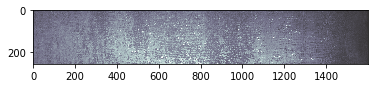

Chosen image has no ground truth mask, rerun the cell


In [49]:
# plot some random images in the `batch`
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.2, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

In [50]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()


In [51]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [52]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [59]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 4
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        #self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.optimizer = RAdam(model.parameters(), lr=self.lr)

        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [62]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 13:52:08
Loss: 5.7955 | dice: 0.0824 | dice_neg: 0.0000 | dice_pos: 0.1445 | IoU: 0.0907
Starting epoch: 0 | phase: val | ⏰: 14:16:19


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 15.90 GiB total capacity; 15.06 GiB already allocated; 27.81 MiB free; 153.04 MiB cached)